In [22]:
import numpy as np 
import pandas as pd

from sklearn.manifold import TSNE

import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from keras.utils.np_utils import to_categorical
from keras.datasets import fashion_mnist

from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
## Download images
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

y_train_dummy = to_categorical(y_train)
y_test_dummy = to_categorical(y_test)

label_dict = {0: 'T-shirt/top',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot'}

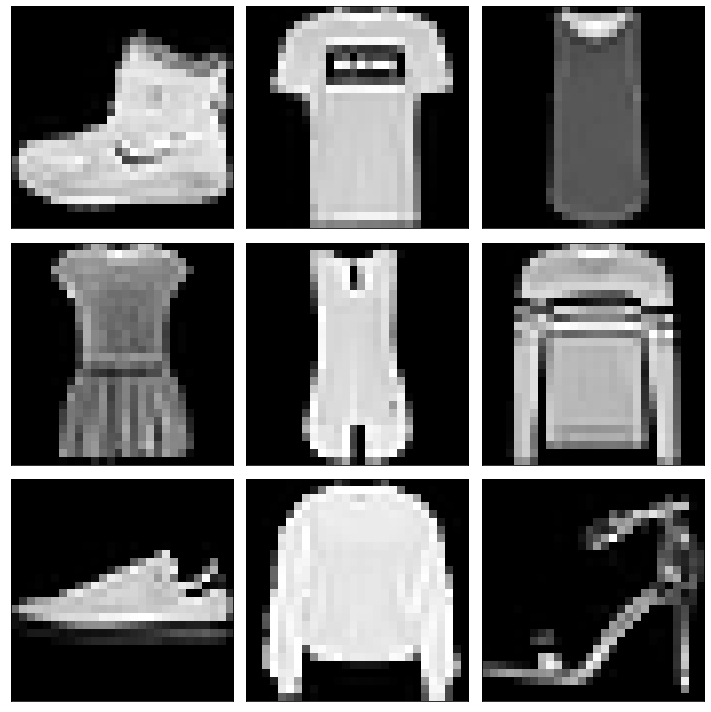

In [3]:
## Display some examples
fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize=(10,10))
cnt = 0

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(x_train[cnt,:,:], cmap='gray')
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
        
        cnt = cnt + 1
fig.tight_layout()

In [4]:
## Embedding using supervised learning
def build_model(lr, l2_reg):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))           
              
    model.add(Flatten())
    model.add(Dense(units=4048, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=4048, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=1000, activation='relu', kernel_regularizer=l2(l2_reg)))
              
    model.add(Dense(units=10, activation='softmax'))
    
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model
                        
    

In [6]:
## Building the model
first_model = build_model(lr=0.001, l2_reg=0.01)
first_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0

In [23]:
## Setup model checkpoint and training.
checkpoint_path = 'ouput/training/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

mcp = ModelCheckpoint(checkpoint_path, 
                      monitor='val_accuracy', 
                      mode='max', 
                      save_best_only=True,
                      save_weights_only=True)

history = first_model.fit(x_train.reshape(x_train.shape[0], 28, 28,1), 
                          y_train_dummy,
                          epochs=100,
                          validation_split=0.2,
                          batch_size=256,
                          verbose=2,
                          callbacks=[mcp]
                          )

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 - 11s - loss: 12.8037 - accuracy: 0.5080 - val_loss: 3.9345 - val_accuracy: 0.7922
Epoch 2/100
48000/48000 - 10s - loss: 2.4720 - accuracy: 0.8386 - val_loss: 1.5271 - val_accuracy: 0.8718
Epoch 3/100
48000/48000 - 10s - loss: 1.1095 - accuracy: 0.8844 - val_loss: 0.8513 - val_accuracy: 0.8724
Epoch 4/100
48000/48000 - 10s - loss: 0.6378 - accuracy: 0.9027 - val_loss: 0.5524 - val_accuracy: 0.8986
Epoch 5/100
48000/48000 - 10s - loss: 0.4285 - accuracy: 0.9131 - val_loss: 0.3962 - val_accuracy: 0.9090
Epoch 6/100
48000/48000 - 10s - loss: 0.3250 - accuracy: 0.9234 - val_loss: 0.3441 - val_accuracy: 0.9119
Epoch 7/100
48000/48000 - 10s - loss: 0.2661 - accuracy: 0.9290 - val_loss: 0.3121 - val_accuracy: 0.9135
Epoch 8/100
48000/48000 - 9s - loss: 0.2272 - accuracy: 0.9360 - val_loss: 0.3129 - val_accuracy: 0.9076
Epoch 9/100
48000/48000 - 10s - loss: 0.2041 - accuracy: 0.9425 - val_loss: 0.2793 - val_accuracy: 0.9

Text(0.5, 1.0, 'Accuracy')

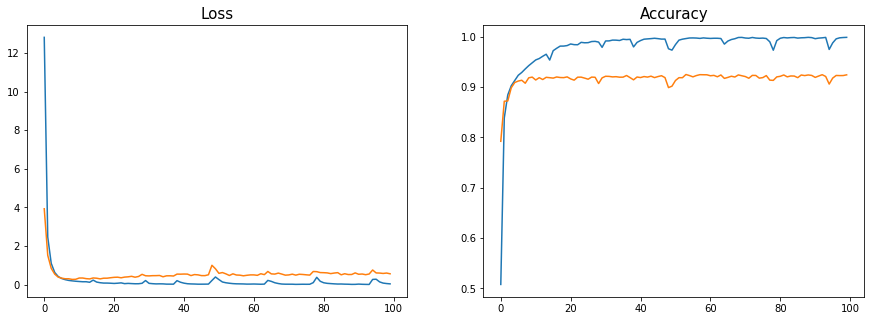

In [44]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_title('Loss', fontsize=15)

ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_title('Accuracy', fontsize=15);

In [26]:
first_model.load_weights('ouput/training/cp.ckpt')
new_model = Sequential()

for layer in first_model.layers[:-4]:
    new_model.add(layer)

new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)        

In [27]:
model_output = new_model.predict(x_train.reshape(x_train.shape[0], 28, 28,1))

In [28]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(model_output)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 23.334s...
[t-SNE] Computed neighbors for 60000 samples in 276.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for

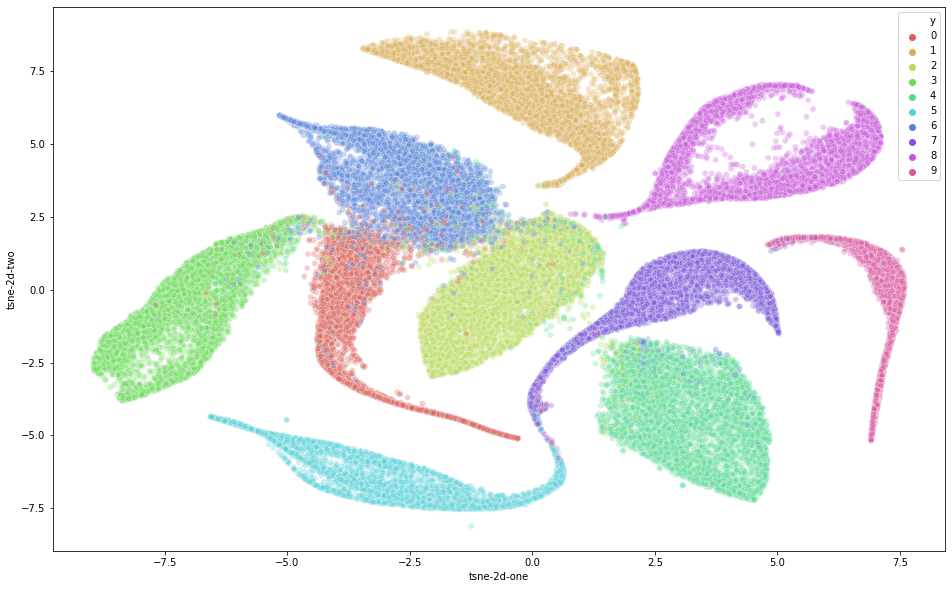

In [29]:
df = pd.DataFrame()

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['y'] = y_train

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

In [4]:
def build_model(lr):
    input_layer = Input(shape=(28,28, 1))
    
    ## Encoding 
    encoding_conv2d_1 = Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
    encoding_maxpool_1 = MaxPooling2D(pool_size=(2,2))(encoding_conv2d_1)
    
    encoding_conv2d_2 = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(encoding_maxpool_1)
    encoding_maxpool_2 = MaxPooling2D(pool_size=(2,2), padding='same')(encoding_conv2d_2)
    
    encoding_conv2d_3 = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(encoding_maxpool_2)
    encoding_maxpool_3 = MaxPooling2D(pool_size=(2,2), padding='same')(encoding_conv2d_3)
    
    
    #encoded_layer = Flatten()(encoding_maxpool_4)
    
    ## Decoding
    decoding_conv2d_1 = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(encoding_maxpool_3)
    decoding_upscale_1 = UpSampling2D(size=(2,2))(decoding_conv2d_1)
    
    decoding_conv2d_2 = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(decoding_upscale_1)
    decoding_upscale_2 = UpSampling2D(size=(2,2))(decoding_conv2d_2)
    
    decoding_conv2d_3 = Conv2D(16, kernel_size=(3,3))(decoding_upscale_2)
    decoding_upscale_3 = UpSampling2D(size=(2,2))(decoding_conv2d_3)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoding_upscale_3)
    
    model = Model(input_layer, decoded)
    
    model.compile(optimizer=Adam(lr=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model
    
cae_model = build_model(0.01)

cae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [ ]:
cae_model.fit(x_train.reshape(len(x_train), 28, 28, 1)[0,:,:,:].reshape(1,28,28,1),
              x_train.reshape(len(x_train), 28, 28, 1)[0,:,:,:].reshape(1,28,28,1),
              epochs=1,
              validation_split=0.2,
              batch_size=1,
              verbose=2)

In [59]:
x_train.reshape(len(x_train), 28, 28, 1)[0,:,:,:].reshape(1,28,28,1)

60000

In [2]:
(1515.372314453125 - 1577.9200439453125)/1577.9200439453125

-0.03963935291410448

In [7]:
-(1538.1781005859375 - 1515.372314453125)/1515.372314453125 + 1

0.9849503742972612

In [8]:
-(1529.00439453125 - 1538.1781005859375)/1538.1781005859375 + 1

1.0059640077122363

In [9]:
(1532.09 - 1529.00439453125)/1529.00439453125 + 1

1.0020180487903019

1.0321790655585101